In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [47]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [48]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [49]:
class NeuralNet:
    def __init__(self, hidden_layer_sizes=(10, ), normalize=True, learning_rate=0.01, max_iter=30000, batch_size=32, momentum=0, epsilon=1e-10):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.num_layers = len(hidden_layer_sizes) + 1
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.normalize = normalize
        self.momentum = momentum
        self.batch_size = batch_size
        self.epsilon = epsilon
        
    def __normalize(self, X, mean=None, std=None):
        if mean is None or std is None:
            mean = np.zeros([X.shape[0], 1])
            std  = np.ones([X.shape[0], 1])

            for i in range(X.shape[0]):
                if (np.std(X[:, i]) != 0):
                    mean[i] = np.mean(X[:, i])
                    std[i] = np.std(X[:, i])
                
        X_new = (X - mean) / std
        return X_new, mean, std
    

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __sigmoid_derivative(self, Z):
        z = self.__sigmoid(Z)
        return np.multiply(z, (1 - z))
    
    def __stable_softmax(self, z):
        exps = np.exp(z - np.max(z))
        return exps / exps.sum(axis=0, keepdims=True)
    
    def __cross_entropy(self, A, Y):
        return -np.mean(Y.T * np.log(A.T))
    
    def __initialize_parameters(self, n_x, n_y, hidden_layers):
        W = []
        b = []
        self.VdW = []
        self.Vdb = []
        
        self.parameters = {}
        layers = [n_x] + list(hidden_layers) + [n_y]
        for i in range(1, self.num_layers + 1):
            W.append(np.random.randn(layers[i], layers[i - 1]) * 0.01)
            b.append(np.zeros((layers[i], 1)))
            
            self.VdW.append(np.zeros((layers[i], layers[i - 1])))
            self.Vdb.append(np.zeros((layers[i], 1)))
        
        self.parameters.update({"W": W, "b": b})
                    
    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]
        
        A = []
        Z = []
        
        for i in range(0, self.num_layers - 1):
            if i == 0:
                Z.append(np.dot(W[i], X) + b[i])
            else:
                Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
        
        Z.append(np.dot(W[-1], A[-1]) + b[-1])
        A.append(self.__stable_softmax(Z[-1]))
        
        cache = (W, b, Z, A)

        return A[-1], cache
    
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None] * self.num_layers
        dA = [None] * self.num_layers
        dZ = [None] * self.num_layers
        db = [None] * self.num_layers
        
        dZ[-1] = A[-1] - Y
        dW[-1] = (1. / m) * np.dot(dZ[-1], A[-2].T)
        db[-1] = (1. / m) * np.sum(dZ[-1], axis = 1, keepdims = True)
        dA[-1] = np.dot(W[-1].T, dZ[-1])
        
        for i in range(self.num_layers-1, 0, -1):
            dZ[i-1] = np.multiply(dA[i], self.__sigmoid_derivative(Z[i-1]))
            if i-1 == 0:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], X.T)
            else:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], A[i-2].T)
            db[i-1] = 1. / m * np.sum(dZ[i-1], axis = 1, keepdims = True) 
            dA[i-1] = np.dot(W[i-1].T, dZ[i-1])
        
        grads = {"dZ" : dZ, "dW" : dW, "db" : db}
        return grads
    
    def __update_parameters(self, grads, iteration):
        for i in range(self.num_layers):
            W = self.parameters[f"W"]
            b = self.parameters[f"b"]
            
            dW = grads[f"dW"]
            db = grads[f"db"]
            
            self.VdW[i] = (self.momentum * self.VdW[i] + (1 - self.momentum) * dW[i] / (1 - self.momentum ** (iteration + 1)))
            self.Vdb[i] = (self.momentum * self.Vdb[i] + (1 - self.momentum) * db[i] / (1 - self.momentum ** (iteration + 1)))

            W[i] = W[i] - self.learning_rate * self.VdW[i]
            b[i] = b[i] - self.learning_rate * self.Vdb[i]
            
            self.parameters = {"W" : W, "b" : b}
    
    def __create_mini_batches(self, X, Y, batch_size):
        m = X.shape[1]
        x_columns = X.shape[0]
        
        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]        
        shuffled_Y = Y[:, permutation]
        data = np.vstack((shuffled_X, shuffled_Y))

        mini_batches = []
        n_minibatches = m // batch_size
        
        for i in range(n_minibatches): 
            mini_batch = data[:, i * batch_size:(i + 1)*batch_size] 
            X_mini = mini_batch[:x_columns, :] 
            Y_mini = mini_batch[x_columns:, :]
            mini_batches.append((X_mini, Y_mini))
        if m % batch_size != 0:
            mini_batch = data[:, (i+1) * batch_size:m] 
            X_mini = mini_batch[:x_columns, :]
            Y_mini = mini_batch[x_columns:, :]
            mini_batches.append((X_mini, Y_mini)) 
        return mini_batches
    
    def fit(self, X_vert, Y_vert, print_cost=True, print_by=1000):
        X, Y = X_vert.T, Y_vert.T
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        costs = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        n_y = Y.shape[0]
        
        self.__initialize_parameters(n_x, n_y, self.hidden_layer_sizes)
        
        for i in range(self.max_iter):
            mini_batches = self.__create_mini_batches(X, Y, self.batch_size) 
            for (X_mini, Y_mini) in mini_batches:
                A, cache = self.__forward_propagation(X_mini)

                cost = self.__cross_entropy(A, Y_mini)

                grads = self.__backward_propagation(X_mini, Y_mini, cache)

                self.__update_parameters(grads, i)

            costs.append(cost)

            if print_cost and i % print_by == 0:
                print("{}-th iteration: {}".format(i, cost))
                if i > 1:
                    print(f"Delta: {costs[-2] - costs[-1]}")

            if i > 1 and abs(costs[-2] - costs[-1]) < self.epsilon:
                break
                
        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel(f"Iteration, *{print_by}")
            plt.show()

    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        y_pred = self.likehood_func(positive_probs)
        return y_pred  

    def likehood_func(self, z):
        return z.argmax(axis=1)

In [50]:
data_columns = ["Sepal length", "Sepal width", "Petal length", "Petal width"]
target_column = "Species"
df = pd.read_csv("iris.csv")
X, Y = df[data_columns].values, df[target_column].values.reshape((df.shape[0], 1))
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(150, 4), y=(150, 1)


0-th iteration: 0.3676568988063584


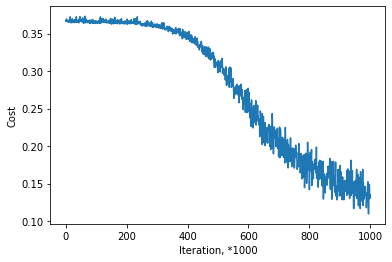

In [51]:
from sklearn.preprocessing import OneHotEncoder

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)
encoder = OneHotEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train).toarray()
y_labels =  [ label[3:] for label in encoder.get_feature_names()]

cls = NeuralNet(hidden_layer_sizes=(50, ), normalize=True, learning_rate = 0.01, max_iter = 1000, batch_size=30, momentum=0, epsilon=1e-8)
cls.fit(X_train, y_train, print_cost=True, print_by=1000)

In [52]:
print(cls.parameters)

{'W': [array([[-0.22415923,  0.07649853, -0.79109839, -0.40575462],
       [-0.04368517,  0.02641932, -0.11871594, -0.05839237],
       [ 0.17299685, -0.04669076,  0.50280117,  0.25763794],
       [-0.10744353,  0.01362462, -0.24925935, -0.14263453],
       [-0.0452021 ,  0.01748242, -0.08888005, -0.05006266],
       [ 0.10893648, -0.01917593,  0.32067204,  0.16100246],
       [-0.22172925,  0.07207801, -0.6952397 , -0.37438614],
       [ 0.14006265, -0.05104521,  0.42795779,  0.21341196],
       [ 0.23058097, -0.0852924 ,  0.71635943,  0.389783  ],
       [-0.04170997,  0.02957566, -0.11422373, -0.05885358],
       [-0.11966336,  0.03573585, -0.28058346, -0.13791826],
       [ 0.05987815, -0.0192065 ,  0.10589912,  0.03477802],
       [-0.17211854,  0.04923648, -0.47395683, -0.2539544 ],
       [ 0.04858512,  0.00293554,  0.07643312,  0.04193325],
       [ 0.08361057, -0.00832233,  0.16242913,  0.08781751],
       [-0.02811652,  0.01385215, -0.08008125, -0.04868262],
       [-0.161323

In [38]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.84621366, 0.14475749, 0.00902885],
       [0.84683571, 0.14420618, 0.0089581 ],
       [0.86576227, 0.1270888 , 0.00714892],
       [0.84996897, 0.14138272, 0.00864831],
       [0.84607203, 0.14488143, 0.00904655],
       [0.79212316, 0.19264216, 0.01523468],
       [0.85815133, 0.13398774, 0.00786094],
       [0.83865026, 0.15154478, 0.00980496],
       [0.86357637, 0.12907796, 0.00734567],
       [0.84384242, 0.14689584, 0.00926174],
       [0.82642909, 0.16244436, 0.01112655],
       [0.83643281, 0.15352805, 0.01003914],
       [0.85578772, 0.13613475, 0.00807753],
       [0.89436827, 0.10088002, 0.00475171],
       [0.84591672, 0.14501807, 0.00906521],
       [0.81165529, 0.17550621, 0.0128385 ],
       [0.83911447, 0.15111835, 0.00976718],
       [0.84069147, 0.14971337, 0.00959516],
       [0.78158976, 0.20180515, 0.01660509],
       [0.83481201, 0.15496847, 0.01021952],
       [0.79713789, 0.18828217, 0.01457995],
       [0.82727674, 0.16168604, 0.01103722],
       [0.

In [43]:
Y_hat = cls.predict(X_test)
Y_hat_labels = [y_labels[i] for i in Y_hat]

In [44]:
accuracy_score(y_test, Y_hat_labels)

1.0